<h1> <b>Sistem Rekomendasi Film<b> <h1>

# Import Library

Mengimport library yang dibutuhkan


In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
import matplotlib.pyplot as plt

# Data Loading

Mengunduh data dari sumber https://www.kaggle.com/datasets/arashnic/book-recommendation-dataset kemudian diunggah melalui *google drive*. Mounted drive ke colab lalu unzip file dan terkahir memuat data ke dalam bentuk dataframe.

variabel yang ada pada dataset:

* books : merupakan daftar buku tersebut.
* ratings : merupakan daftar penilaian yang diberikan pengguna terhadap buku.
* users : merupakan daftar pengguna.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/MyDrive/Dataset/Book recomendation.zip"

Archive:  /content/drive/MyDrive/Dataset/Book recomendation.zip
  inflating: Books.csv               
  inflating: Ratings.csv             
  inflating: Users.csv               
  inflating: recsys_taxonomy2.png    


In [ ]:
books = pd.read_csv('/content/Books.csv')
ratings = pd.read_csv('/content/Ratings.csv')
users = pd.read_csv('/content/Users.csv')

<ipython-input-4-013a2cca4fde>:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  books = pd.read_csv('/content/Books.csv')


# EDA - Analisis Univariate
Analisis univariate merupakan proses untuk mengeksplorasi dan menjelaskan setiap variabel dalam kumpulan data secara terpisah.

## Variabel books

In [ ]:
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271360 non-null  object
 1   Book-Title           271360 non-null  object
 2   Book-Author          271359 non-null  object
 3   Year-Of-Publication  271360 non-null  object
 4   Publisher            271358 non-null  object
 5   Image-URL-S          271360 non-null  object
 6   Image-URL-M          271360 non-null  object
 7   Image-URL-L          271357 non-null  object
dtypes: object(8)
memory usage: 16.6+ MB


Dapat dilihat bahwa :

*   Terdapat 271360 data dalam books
*   Terdapat 8 buah kolom bertipe objek yaitu ISBN, Book-Title, Book-Author,Year-Of-Publication, Publisher, Image-URL-S, Image-URL-M dan Image-URL-L.



In [ ]:
print('Jumlah data buku : ', len(books.ISBN.unique()))

Jumlah data buku :  271360


Dapat dilihat bahwa jumlah data buku berdasarkan ISBN sebanyak 271360

## Variabel users

In [ ]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   User-ID   278858 non-null  int64  
 1   Location  278858 non-null  object 
 2   Age       168096 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 6.4+ MB


Dapat dilihat bahwa :

*   Terdapat 278858 data dalam users
*   Terdapat 1 buah kolom bertipe int64 yaitu User-ID.
*   Terdapat 1 buah kolom bertipe object yaitu Location.
*   Terdapat 1 buah kolom bertipe float64 yaitu Age.


In [ ]:
print('Jumlah data pengguna : ', len(users['User-ID'].unique()))

Jumlah data pengguna :  278858


## Variabel ratings

In [ ]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   User-ID      1149780 non-null  int64 
 1   ISBN         1149780 non-null  object
 2   Book-Rating  1149780 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


Dapat dilihat bahwa :

*   Terdapat 1149780 data dalam ratings.
*   Terdapat 2 buah kolom bertipe int64 yaitu User-ID dan Book-rating.
*   Terdapat 1 buah kolom bertipe object yaitu ISBN.

Karena data terlalu banyak, maka data yang akan digunakan hanya 30000 data saja

In [ ]:
# mengambil data sebanyak 30000
ratings = ratings.iloc[:30000,:]

In [ ]:
# cek bentuk data
ratings.shape

(30000, 3)

In [ ]:
print('Jumlah data ratings dari user : ', len(ratings['User-ID'].unique()))
print('Jumlah data ratings dari buku : ', len(ratings.ISBN.unique()))

Jumlah data ratings dari user :  3445
Jumlah data ratings dari buku :  24009


In [ ]:
ratings.describe()

,User-ID,Book-Rating
count,30000.000000,30000.000000
mean,91215.561800,3.062533
std,127794.304756,3.901264
min,2.000000,0.000000
25%,2977.000000,0.000000
50%,5790.000000,0.000000
75%,277478.000000,7.000000
max,278854.000000,10.000000


Dapat kita lihat dari nilai max dan min bahwa nilai rating terbesar yaitu 10 dan nilai rating terkecil yaitu 0

# Content Based Filtering

## Data Preprocessing



### Menggabungkan Book

In [ ]:
import numpy as np

# Menggabungkan seluruh ISBN pada kategori books
books_all = np.concatenate((
    books.ISBN.unique(),
    ratings.ISBN.unique(),
))

# Mengurutkan data dan menghapus data yang sama
books_all = np.sort(np.unique(books_all))

print('Jumlah seluruh data buku berdasarkan ISBN: ', len(books_all))

Jumlah seluruh data buku berdasarkan ISBN:  275336


### Menggabungkan User

In [ ]:
# Menggabungkan seluruh User-ID
user_all = np.concatenate((
    ratings['User-ID'].unique(),
    users['User-ID'].unique()
))

# Menghapus data yang sama kemudian mengurutkannya
user_all = np.sort(np.unique(user_all))

print('Jumlah seluruh user: ', len(user_all))

Jumlah seluruh user:  278858


### Menggabungkan seluruh data dengan fitur nama buku

In [ ]:
# Definisikan dataframe rating ke dalam variabel all_books_rate
all_books_rate = ratings
all_books_rate

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6
...,...,...,...
29995,7105,0140120831,10
29996,7105,014012389X,8
29997,7105,014014305X,6
29998,7105,014023750X,0


In [ ]:
all_books = pd.merge(all_books_rate, books[['ISBN','Book-Title','Book-Author','Year-Of-Publication','Publisher']], on='ISBN', how='left')
all_books

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher
0,276725,034545104X,0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books
1,276726,0155061224,5,Rites of Passage,Judith Rae,2001,Heinle
2,276727,0446520802,0,The Notebook,Nicholas Sparks,1996,Warner Books
3,276729,052165615X,3,Help!: Level 1,Philip Prowse,1999,Cambridge University Press
4,276729,0521795028,6,The Amsterdam Connection : Level 4 (Cambridge ...,Sue Leather,2001,Cambridge University Press
...,...,...,...,...,...,...,...
29995,7105,0140120831,10,NaN,NaN,NaN,NaN
29996,7105,014012389X,8,Love in the Time of Cholera,Gabriel Garcia Marquez,1998,Penguin Books Ltd
29997,7105,014014305X,6,NaN,NaN,NaN,NaN
29998,7105,014023750X,0,NaN,NaN,NaN,NaN


## Data Preparation

### Menangani missing value

Melakukan pengecekan terlebih dahulu apakah didalam dataset terdapat missing value dengan kode berikut :

In [ ]:
# cek missing value
all_books.isnull().sum()

User-ID                   0
ISBN                      0
Book-Rating               0
Book-Title             4172
Book-Author            4172
Year-Of-Publication    4172
Publisher              4172
dtype: int64

Terdapat 41772 missing value terhadap fitur Book-Title, Book-Author,Year-Of-Publication, dan Publisher. Karena tidak bisa mengidentifikasi nama bukunya oleh karena itu akan di drop fitur tag menggunakan dropna

In [ ]:
all_books_clean = all_books.dropna()
all_books_clean

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher
0,276725,034545104X,0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books
1,276726,0155061224,5,Rites of Passage,Judith Rae,2001,Heinle
2,276727,0446520802,0,The Notebook,Nicholas Sparks,1996,Warner Books
3,276729,052165615X,3,Help!: Level 1,Philip Prowse,1999,Cambridge University Press
4,276729,0521795028,6,The Amsterdam Connection : Level 4 (Cambridge ...,Sue Leather,2001,Cambridge University Press
...,...,...,...,...,...,...,...
29986,7105,0099428644,0,The Trial,Franz Kafka,2001,Vintage
29993,7105,0140063838,7,Clinging to the Wreckage,John Mortimer,1983,Penguin Books Ltd
29994,7105,0140071814,5,The Kingdom by the Sea: A Journey Around the C...,Paul Theroux,1995,Penguin Books
29996,7105,014012389X,8,Love in the Time of Cholera,Gabriel Garcia Marquez,1998,Penguin Books Ltd


In [ ]:
# cek ulang missing value
all_books_clean.isnull().sum()

User-ID                0
ISBN                   0
Book-Rating            0
Book-Title             0
Book-Author            0
Year-Of-Publication    0
Publisher              0
dtype: int64

Missing value sudah tidak ada

### Mengurutkan Data

Mengurutkan data secara ascending

In [ ]:
# mengurutkan film berdasarkan ISBN ke dalam variabel fix_books
fix_books = all_books_clean.sort_values('ISBN', ascending=True)
fix_books

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher
28129,6575,0001714600,0,I Want to Be Somebody New! (I Can Read It All ...,Robert Lopshire,1986,HarperCollins Publishers
9563,8,0002005018,5,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
24662,5899,000221122X,0,The candywine development,John Morris,1970,Collins
3311,277996,0002240114,6,The Dixon Cornbelt League and other baseball s...,W. P Kinsella,1993,HarperCollins
24717,5903,0002243776,0,Visible Worlds: A Novel,Marilyn Bowering,1997,Harpercollins Canada
...,...,...,...,...,...,...,...
27057,6366,B00005BBW4,0,Sense and Sensibility,Jane Austen,0,Random House
12861,1424,B00008NRHQ,0,"Mystic Rose, The",Stephen R. Lawhead,2001,Zondervan
24322,5673,B00009ANY9,0,Cane River,Lalita Tademy,2001,Warner Books
16855,2891,B00009ANY9,0,Cane River,Lalita Tademy,2001,Warner Books


In [ ]:
# cek jumlah fix books
len(fix_books.ISBN.unique())

20033

In [ ]:
# Membuat variabel preparation yang berisi dataframe fix_book kemudian mengurutkan berdasarkan ISBN
preparation = fix_books
preparation.sort_values('ISBN', ascending=True)

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher
28129,6575,0001714600,0,I Want to Be Somebody New! (I Can Read It All ...,Robert Lopshire,1986,HarperCollins Publishers
9563,8,0002005018,5,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
24662,5899,000221122X,0,The candywine development,John Morris,1970,Collins
3311,277996,0002240114,6,The Dixon Cornbelt League and other baseball s...,W. P Kinsella,1993,HarperCollins
24717,5903,0002243776,0,Visible Worlds: A Novel,Marilyn Bowering,1997,Harpercollins Canada
...,...,...,...,...,...,...,...
27057,6366,B00005BBW4,0,Sense and Sensibility,Jane Austen,0,Random House
12861,1424,B00008NRHQ,0,"Mystic Rose, The",Stephen R. Lawhead,2001,Zondervan
16855,2891,B00009ANY9,0,Cane River,Lalita Tademy,2001,Warner Books
24322,5673,B00009ANY9,0,Cane River,Lalita Tademy,2001,Warner Books


### Menangani data duplikat

Menghapus data yang duplikat dengan fungsi drop_duplicates(). Dalam hal ini, membuang data duplikat pada kolom ‘ISBN’.

In [ ]:
# Membuang data duplikat pada variabel preparation
preparation = preparation.drop_duplicates('ISBN')
preparation

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher
28129,6575,0001714600,0,I Want to Be Somebody New! (I Can Read It All ...,Robert Lopshire,1986,HarperCollins Publishers
9563,8,0002005018,5,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
24662,5899,000221122X,0,The candywine development,John Morris,1970,Collins
3311,277996,0002240114,6,The Dixon Cornbelt League and other baseball s...,W. P Kinsella,1993,HarperCollins
24717,5903,0002243776,0,Visible Worlds: A Novel,Marilyn Bowering,1997,Harpercollins Canada
...,...,...,...,...,...,...,...
11595,805,9997522052,0,Collected Works of Emile Zola,Emile Zola,2001,Chatto &amp; Windus
27057,6366,B00005BBW4,0,Sense and Sensibility,Jane Austen,0,Random House
12861,1424,B00008NRHQ,0,"Mystic Rose, The",Stephen R. Lawhead,2001,Zondervan
24322,5673,B00009ANY9,0,Cane River,Lalita Tademy,2001,Warner Books


### Konversi data menjadi list

Melakukan konversi data series menjadi list. Dalam hal ini, menggunakan fungsi tolist() dari library numpy.

In [ ]:
# Mengonversi data series ISBN menjadi dalam bentuk list
book_id = preparation['ISBN'].tolist()

# Mengonversi data series ‘Book-Title’ menjadi dalam bentuk list
book_name = preparation['Book-Title'].tolist()

# Mengonversi data series ‘Book-Author’ menjadi dalam bentuk list
book_author = preparation['Book-Author'].tolist()

book_publish = preparation['Publisher'].tolist()

print(len(book_id))
print(len(book_name))
print(len(book_author))
print(len(book_publish))

20033
20033
20033
20033


### Membuat Dictionary
Membuat dictionary untuk menentukan pasangan key-value pada data book_id, book_name, book_author, dan book_publish yang telah disiapkan sebelumnya

In [ ]:
# Membuat dictionary untuk data book_id, book_name, book_author, dan book_publish
book_new = pd.DataFrame({
    'id': book_id,
    'book_name':book_name,
    'author': book_author,
    'publisher': book_publish
})
book_new

,id,book_name,author,publisher
0,0001714600,I Want to Be Somebody New! (I Can Read It All ...,Robert Lopshire,HarperCollins Publishers
1,0002005018,Clara Callan,Richard Bruce Wright,HarperFlamingo Canada
2,000221122X,The candywine development,John Morris,Collins
3,0002240114,The Dixon Cornbelt League and other baseball s...,W. P Kinsella,HarperCollins
4,0002243776,Visible Worlds: A Novel,Marilyn Bowering,Harpercollins Canada
...,...,...,...,...
20028,9997522052,Collected Works of Emile Zola,Emile Zola,Chatto &amp; Windus
20029,B00005BBW4,Sense and Sensibility,Jane Austen,Random House
20030,B00008NRHQ,"Mystic Rose, The",Stephen R. Lawhead,Zondervan
20031,B00009ANY9,Cane River,Lalita Tademy,Warner Books


## Modelling

### TF-IDF Vectorizer
Digunakan untuk menemukan representasi fitur penting dari setiap penulis buku.
Menggunakan fungsi tfidfvectorizer() dari library sklearn.

In [ ]:

from sklearn.feature_extraction.text import TfidfVectorizer

# Inisialisasi TfidfVectorizer
tfid = TfidfVectorizer()

# Melakukan perhitungan idf pada data author
tfid.fit(book_new['author'])

# Mapping array dari fitur index integer ke fitur nama
tfid.get_feature_names_out()

array(['aa', 'aardema', 'aaron', ..., 'â¼ffel', 'â¼nter', 'â¼skind'],
      dtype=object)

In [ ]:
# Melakukan fit lalu ditransformasikan ke bentuk matrix
tfidf_matrix = tfid.fit_transform(book_new['author'])

# Melihat ukuran matrix tfidf
tfidf_matrix.shape

(20033, 8832)

Dapat dilihat matriks yang dimiliki berukuran (20033, 8832). Nilai 20033 merupakan ukuran data dan 8832 merupakan matrik penulis buku

In [ ]:
# Mengubah vektor tf-idf dalam bentuk matriks dengan fungsi todense()
tfidf_matrix.todense()

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
# Membuat dataframe untuk melihat tf-idf matrix
# Kolom diisi dengan author
# Baris diisi dengan nama buku

pd.DataFrame(
    tfidf_matrix.todense(),
    columns=tfid.get_feature_names_out(),
    index=book_new.book_name
).sample(10, axis=1,replace=True).sample(10, axis=0,replace=True)

,strindberg,bluth,baudrillard,francesca,self,dunford,trevanian,shields,popescu,august
book_name,,,,,,,,,,
Wizard of Oz (Aladdin Classics),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
The Sum of All Fears,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
The Vision of Emma Blau,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Das Lacheln der Fortuna: Historischer Roman,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Two solitudes,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
The Green Suit,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Paddington's Shopping Adventure,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Servant of the Bones,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Hollywood: A Novel of America in the 1920's,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Cosine Similarity
Menghitung derajat kesamaan (similarity degree) antar buku dengan teknik cosine similarity. Dengan menggunakan fungsi cosine_similarity dari library sklearn.

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim = cosine_similarity(tfidf_matrix)
cosine_sim

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [ ]:
# Membuat dataframe dari variabel cosine_sim dengan baris dan kolom berupa nama buku
cosine_sim_df = pd.DataFrame(cosine_sim, index=book_new['book_name'], columns=book_new['book_name'])
print('Shape:', cosine_sim_df.shape)

# Melihat similarity matrix pada setiap buku
cosine_sim_df.sample(5, axis=1).sample(10, axis=0)

Shape: (20033, 20033)


book_name,Le Bouddha de banlieue,CAT'S EYE,The Wordsworth Dictionary of Proverbs (Wordsworth Collection),Hard Eight : A Stephanie Plum Novel (A Stephanie Plum Novel),Frankenstein Doesn't Plant Petunias (Adventures of the Bailey School Kids (Paperback))
book_name,,,,,
The Complete Short Stories of Mark Twain (Bantam Classic),0.0,0.0,0.0,0.0,0.0
The Upside Down Riddle Book,0.0,0.0,0.0,0.0,0.0
Gallow's View (Inspector Banks Mysteries (Paperback)),0.0,0.0,0.0,0.0,0.0
The Internet Church,0.0,0.0,0.0,0.0,0.0
Sleeping on the Wing : An Anthology of Modern Poetry with Essays on Reading and Writing,0.0,0.0,0.0,0.0,0.0
Boychiks in the Hood : Travels in the Hasidic Underground,0.0,0.0,0.0,0.0,0.0
Timepiece,0.0,0.0,0.0,0.0,0.0
Happy are the clean of heart: A Father Blackie Ryan story,0.0,0.0,0.0,0.0,0.0
Brideshead Regained,0.0,0.0,0.0,0.0,0.0


## Evaluasi

### Mendapatkan Rekomendasi
Membuat fungsi book_recommendations dengan beberapa parameter sebagai berikut:

* Nama_buku : Nama judul dari buku tersebut (index kemiripan dataframe).
* Similarity_data : Dataframe mengenai similarity yang telah kita didefinisikan sebelumnya
* Items : Nama dan fitur yang digunakan untuk mendefinisikan kemiripan, dalam hal ini adalah ‘book_name’ dan ‘author’.
* k : Banyak rekomendasi yang ingin diberikan.

In [ ]:
def book_recommendations(nama_book, similarity_data=cosine_sim_df, items=book_new[['book_name', 'author']], k=5):


    # Mengambil data dengan menggunakan argpartition untuk melakukan partisi secara tidak langsung sepanjang sumbu yang diberikan
    # Dataframe diubah menjadi numpy
    # Range(start, stop, step)
    index = similarity_data.loc[:,nama_book].to_numpy().argpartition(
        range(-1, -k, -1))

    # Mengambil data dengan similarity terbesar dari index yang ada
    closest = similarity_data.columns[index[-1:-(k+2):-1]]

    # Drop nama_buku agar nama buku yang dicari tidak muncul dalam daftar rekomendasi
    closest = closest.drop(nama_book, errors='ignore')

    return pd.DataFrame(closest).merge(items).head(k)

In [ ]:
book_new[book_new.book_name.eq('Wizard of Oz (Aladdin Classics)')]

,id,book_name,author,publisher
13690,0689831420,Wizard of Oz (Aladdin Classics),L. Frank Baum,Aladdin


In [ ]:
# mendapatkan rekomendasi buku yang mirip dengan 'Wizard of Oz (Aladdin Classics)'
book_recommendations('Wizard of Oz (Aladdin Classics)')

,book_name,author
0,Dorothy and the Wizard of Oz (Complete and Una...,L. Frank Baum
1,Der Zauberer Von Oos,Frank L. Baum
2,The Wizard of Oz,L. Frank Baum
3,Aerie Tik Tok of Oz: Defiant-Cn16dp,Baum
4,The Diary of a Young Girl: The Definitive Edition,Anne Frank


# Collaborative Filtering

## Data Understanding
Supaya tidak tertukar dengan fitur ‘rating’ pada data, kita ubah nama variabel rating menjadi df

In [ ]:
# Membaca dataset
df = ratings
df

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6
...,...,...,...
29995,7105,0140120831,10
29996,7105,014012389X,8
29997,7105,014014305X,6
29998,7105,014023750X,0


Dapat dilihat, data ratings memiliki 30000 baris dan 3 kolom

## Data Preparation



### Encode fitur User-ID dan ISBN
Melakukan persiapan data untuk menjadikan (encode) fitur ‘User-ID’ dan ‘ISBN’ ke dalam indeks integer

In [ ]:
# Mengubah User-ID menjadi list tanpa nilai yang sama
user_ids = df['User-ID'].unique().tolist()
print('list User-ID: ', user_ids)

# Melakukan encoding User-ID
user_to_user_encoded = {x: i for i, x in enumerate(user_ids)}
print('encoded User-ID : ', user_to_user_encoded)

# Melakukan proses encoding angka ke User-ID
user_encoded_to_user = {i: x for i, x in enumerate(user_ids)}
print('encoded angka ke User-ID: ', user_encoded_to_user)

list userId:  [276725, 276726, 276727, 276729, 276733, 276736, 276737, 276744, 276745, 276746, 276747, 276748, 276751, 276754, 276755, 276760, 276762, 276765, 276768, 276772, 276774, 276780, 276786, 276788, 276796, 276798, 276800, 276803, 276804, 276806, 276808, 276811, 276812, 276813, 276814, 276817, 276820, 276822, 276827, 276828, 276830, 276832, 276833, 276835, 276837, 276838, 276840, 276842, 276847, 276848, 276850, 276852, 276853, 276854, 276856, 276857, 276859, 276861, 276862, 276863, 276866, 276869, 276870, 276872, 276873, 276875, 276878, 276879, 276884, 276887, 276888, 276889, 276890, 276896, 276904, 276905, 276911, 276912, 276915, 276916, 276925, 276927, 276928, 276929, 276934, 276936, 276939, 276943, 276946, 276949, 276950, 276953, 276954, 276957, 276959, 276963, 276964, 276965, 276975, 276981, 276984, 276986, 276988, 276989, 276990, 276992, 276994, 276997, 276998, 277002, 277007, 277009, 277010, 277012, 277018, 277019, 277022, 277023, 277028, 277031, 277032, 277035, 277036, 2

In [ ]:
# Mengubah ISBN menjadi list tanpa nilai yang sama
book_ids = df['ISBN'].unique().tolist()

# Melakukan proses encoding ISBN
book_to_book_encoded = {x: i for i, x in enumerate(book_ids)}

# Melakukan proses encoding angka ke ISBN
book_encoded_to_book = {i: x for i, x in enumerate(book_ids)}

### Memetakan User-ID dan ISBN
Petakan  User-ID dan ISBN ke dataframe yang berkaitan.

In [ ]:
# Mapping User-ID ke dataframe author
df['author'] = df['User-ID'].map(user_to_user_encoded)

# Mapping ISBN ke dataframe books
df['books'] = df['ISBN'].map(book_to_book_encoded)

### Cek data dan ubah nilai rating
Terakhir, cek beberapa hal dalam data seperti jumlah user, jumlah book, dan mengubah nilai rating menjadi float, cek nilai minimum dan maximum

In [ ]:
num_users = len(user_to_user_encoded)
print(num_users)

num_book = len(book_encoded_to_book)
print(num_book)

df['ratings'] = df['Book-Rating'].values.astype(np.float32)

min_rating = min(df['Book-Rating'])

max_rating = max(df['Book-Rating'])

print('Number of User: {}, Number of book: {}, Min Rating: {}, Max Rating: {}'.format(
    num_users, num_book, min_rating, max_rating
))

3445
24009
Number of User: 3445, Number of book: 24009, Min Rating: 0, Max Rating: 10


### Membagi data untuk latih dan validasi

membagi data latih dan validasi dengan komposisi 80:20

In [ ]:
# Mengacak dataset
df = df.sample(frac=1, random_state=42)
df

,User-ID,ISBN,Book-Rating,author,ratings,books
905,277155,1558744592,0,158,0.0,893
13390,1733,0373301626,0,1450,0.0,12013
10770,503,0809244942,10,1025,10.0,9954
13422,1733,038075620X,0,1450,0.0,12040
27020,6360,8422616467,8,3161,8.0,22170
...,...,...,...,...,...,...
21020,4070,0670871753,0,2313,0.0,17956
13019,1485,0072453907,0,1358,0.0,11730
1676,277427,0449221504,0,255,0.0,1633
10967,585,8807120194,7,1048,7.0,10108


In [ ]:
# Membuat variabel x untuk mencocokkan data author dan books menjadi satu value
x = df[['author', 'books']].values

# Membuat variabel y untuk membuat ratings dari hasil
y = df['ratings'].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

# Membagi menjadi 80% data train dan 20% data validasi
train_indices = int(0.8 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:]
)

print(x, y)

[[  158   893]
 [ 1450 12013]
 [ 1025  9954]
 ...
 [  255  1633]
 [ 1048 10108]
 [ 2836 20220]] [0.  0.  1.  ... 0.  0.7 0.8]


## Modelling

### Proses Latih

Membuat class RecommenderNet dengan keras Model class. Model ini menggunakan Binary Crossentropy untuk menghitung loss function, Adam (Adaptive Moment Estimation) sebagai optimizer, dan root mean squared error (RMSE) sebagai metrics evaluation

In [ ]:
class RecommenderNet(tf.keras.Model):

  # Insialisasi fungsi
  def __init__(self, num_users, num_book, embedding_size, **kwargs):
    super(RecommenderNet, self).__init__(**kwargs)
    self.num_users = num_users
    self.num_book = num_book
    self.embedding_size = embedding_size
    self.user_embedding = layers.Embedding( # layer embedding user
        num_users,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.user_bias = layers.Embedding(num_users, 1) # layer embedding user bias
    self.book_embedding = layers.Embedding( # layer embeddings book
        num_book,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.book_bias = layers.Embedding(num_book, 1) # layer embedding book bias

  def call(self, inputs):
    user_vector = self.user_embedding(inputs[:,0]) # memanggil layer embedding 1
    user_bias = self.user_bias(inputs[:, 0]) # memanggil layer embedding 2
    book_vector = self.book_embedding(inputs[:, 1]) # memanggil layer embedding 3
    book_bias = self.book_bias(inputs[:, 1]) # memanggil layer embedding 4

    dot_user_book = tf.tensordot(user_vector, book_vector, 2)

    x = dot_user_book + user_bias + book_bias

    return tf.nn.sigmoid(x) # activation sigmoid

In [ ]:
model = RecommenderNet(num_users, num_book, 50) # inisialisasi model

# model compile
model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(learning_rate=0.001),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

In [ ]:
# Memulai training

history = model.fit(
    x = x_train,
    y = y_train,
    batch_size = 8,
    epochs = 50,
    validation_data = (x_val, y_val)
)

Epoch 1/50
3000/3000 [==============================] - 15s 4ms/step - loss: 0.6230 - root_mean_squared_error: 0.3957 - val_loss: 0.5713 - val_root_mean_squared_error: 0.3660
Epoch 2/50
3000/3000 [==============================] - 12s 4ms/step - loss: 0.5299 - root_mean_squared_error: 0.3445 - val_loss: 0.5444 - val_root_mean_squared_error: 0.3529
Epoch 3/50
3000/3000 [==============================] - 11s 4ms/step - loss: 0.5041 - root_mean_squared_error: 0.3296 - val_loss: 0.5329 - val_root_mean_squared_error: 0.3473
Epoch 4/50
3000/3000 [==============================] - 12s 4ms/step - loss: 0.4859 - root_mean_squared_error: 0.3180 - val_loss: 0.5268 - val_root_mean_squared_error: 0.3439
Epoch 5/50
3000/3000 [==============================] - 12s 4ms/step - loss: 0.4703 - root_mean_squared_error: 0.3076 - val_loss: 0.5237 - val_root_mean_squared_error: 0.3422
Epoch 6/50
3000/3000 [==============================] - 11s 4ms/step - loss: 0.4580 - root_mean_squared_error: 0.2995 - val_l

## Evaluasi

Evaluasi dilakukan dengan menggunakan matriks Root Mean Squared Error (RMSE). Root Mean Square Error adalah hasil dari akar kuadrat Mean Square Error. Mean Square Error yaitu menghitung jumlah selisih kuadrat rata-rata nilai sebenarnya dengan nilai prediksi.

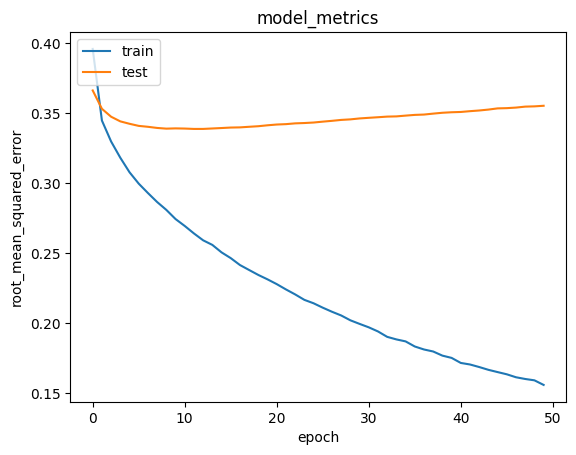

In [ ]:
# Visualisasi RMSE
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model_metrics')
plt.ylabel('root_mean_squared_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Proses training model cukup smooth dan model konvergen pada epochs sekitar 50. Dari proses ini, kita memperoleh nilai error akhir sebesar sekitar 0.15 dan error pada data validasi sebesar 0.35 . Nilai tersebut cukup bagus untuk sistem rekomendasi.

### Mendapatkan Rekomendasi

Untuk mendapatkan rekomendasi buku, pertama kita ambil sampel user secara acak dan definisikan variabel book_not_read yang merupakan daftar buku yang belum pernah dibaca oleh pengguna

In [ ]:
book_df = book_new
df = pd.read_csv('/content/Ratings.csv')
# mengambil data sebanyak 30000
df = df.iloc[:30000,:]

user_id = df['User-ID'].sample(1).iloc[0]
book_read_by_user = df[df['User-ID'] == user_id]


book_not_read = book_df[~book_df['id'].isin(book_read_by_user.ISBN.values)]['id']
book_not_read = list(
    set(book_not_read)
    .intersection(set(book_to_book_encoded.keys()))
)

book_not_read = [[book_to_book_encoded.get(x)] for x in book_not_read]
user_encoder = user_to_user_encoded.get(user_id)
user_book_array = np.hstack(
    ([[user_encoder]] * len(book_not_read), book_not_read)
)

In [ ]:
# untuk memperoleh rekomendasi buku, gunakan fungsi model.predict() dari library Keras
ratings = model.predict(user_book_array).flatten()

top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_book_ids = [
    book_encoded_to_book.get(book_not_read[x][0]) for x in top_ratings_indices
]

print('Showing recommendations for users: {}'.format(user_id))
print('===' * 9)
print('book with high ratings from user')
print('----' * 8)

top_book_user = (
    book_read_by_user.sort_values(
        by = 'Book-Rating',
        ascending=False
    )
    .head(5)
    .ISBN.values
)

book_df_rows = book_df[book_df['id'].isin(top_book_user)]
for row in book_df_rows.itertuples():
    print(row.book_name, ':', row.author)

print('----' * 8)
print('Top 10 book recommendation')
print('----' * 8)

recommended_book = book_df[book_df['id'].isin(recommended_book_ids)]
for row in recommended_book.itertuples():
    print(row.book_name, ':', row.author)

611/611 [==============================] - 1s 2ms/step
Showing recommendations for users: 277427
book with high ratings from user
--------------------------------
Politically Correct Bedtime Stories: Modern Tales for Our Life and Times : James Finn Garner
Its Obvious You Wont Survive By Your Wit : Scott Adams
Unnatural Selections : Gary Larson
Dilbert Fugitive From The Cubicle Police : Scott Adams
Dilbert: Seven Years Of Highly Defective People (P : Scott Adams
--------------------------------
Top 10 book recommendation
--------------------------------
Suzanne's Diary for Nicholas : James Patterson
Fg on Our Immigrant Ance : J Smith
The Giver (21st Century Reference) : LOIS LOWRY
A Wrinkle in Time : Madeleine L'Engle
Scales of Justice (Return of the Dragon Fanuilh) : Daniel Hood
To Kill a Mockingbird : Harper Lee
Making Minty Malone : Isabel Wolff
1984 : George Orwell
The Millionaire Next Door: The Surprising Secrets of America's Wealthy : Thomas J. Stanley
Kushiel's Dart : Jacqueline 